<a href="https://colab.research.google.com/github/jmcinern/NLP_QUB/blob/main/WordsAsVectors_JosephMcInerney_40460549_section2code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representing Words as Vectors for Text Classification


## 2.0 Prepare Data and Models

### 2.0a

In [ ]:
RANDOM_STATE = 40460549

Use already downloaded and stored word2vec model

In [ ]:
# Mount g-drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# load word2vec model
from gensim.models import KeyedVectors

model_path = "/content/drive/MyDrive/NLP/Lab6/word2vec-google-news-300.kv"
word2vec_model = KeyedVectors.load(model_path, mmap='r')

### 2.0b Load Stories Dataset JSON

In [ ]:
import json, os
# Stories dataset in same dir as notebook.
pth = '/content/drive/MyDrive/NLP/Project/'
fn = 'stories.json'
with open(os.path.join(pth, fn), 'r') as ifh:
    data = json.load(ifh)

## 2.1 Text Classification with Word2Vec

### 2.1a Representing Text as a Feature Vector


"For each story, get a feature vector for the text by averaging the text’s word2vec embeddings (ignoring stop words)"

In [ ]:
import spacy
# only using spacy for tokenization and stop word checking so can disable other features
# -that get processed
nlp = spacy.load("en_core_web_sm", enable=['tok2vec'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np


def story2feature_vector(story, word2vec_model):
  # initialise list of word vectors
  word_vecs = []

  # for word in doc
  for word in story:

    # ignoring stop words
    if not word.is_stop:

      # get embedding using word2vec if word exists in model
      if word.text in word2vec_model:

        # Get embedding and add to list
        embedding = word2vec_model[word.text]
        word_vecs.append(embedding)

  # return mean of word vectors to represent document FV,
  # axis=0: sum over words: returns vector and not default scalar
  return np.mean(word_vecs, axis=0)

In [ ]:
from tqdm import tqdm # track progress as lots of stories

# Story feature vectors FVs for each doc, constructing the design matrix for classification
story_fvs_X = []
# also store stories not as FVs for later comparison with BERT
stories_X = []
# Get length of stories (tokens) for specifying BERT MAX_LEN later on.
stories_len =[]
# The target vector which is the corresponding setting for each story.
settings_y = []
for story in tqdm(data['stories']):
  # get text
  story_txt = story['story']
  # add story, no need to turn into NLP obj as BERT will specify tokenizer later
  stories_X.append(story_txt)
  # split text into sentences (spaCy nlp obj)
  story_doc = nlp(story_txt)
  # for BERT MAX_LEN
  stories_len.append(len(story_doc))
  # X: get feature FV of story which is the mean of all of its word embeddings.
  story_fv = story2feature_vector(story_doc, word2vec_model)
  # append FV to X
  story_fvs_X.append(story_fv)

  # y: get corresponding setting based on JSON idx
  settings_y.append(story['setting'])

100%|██████████| 602/602 [00:31<00:00, 19.35it/s]


# TODO: Visualise class balance

### 2.1b Classifying Stories by Setting using Text Feature Vctors

In [ ]:
# Convert lists of FVs and target variable to np.array(), more suitable for ML
story_fvs_X_np= np.array(story_fvs_X)
settings_y_np = np.array(settings_y)

In [ ]:
story_fvs_X_np.shape

(602, 300)

#### Train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data for train/test
X_train, X_test, y_train, y_test = train_test_split(
    story_fvs_X_np, settings_y_np, test_size=0.2, random_state=RANDOM_STATE
)

# random forest
RF_clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

# Fit the classifier on training data
RF_clf.fit(X_train, y_train)

# predict on the testing data
y_pred = RF_clf.predict(X_test)

# compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.743801652892562


#### Test

## 2.2 Text Classification with BERT

### 2.2a Set up Data Loader

In [ ]:
# Using the same train test split

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Get train/val/test sets, use same random state so test set is the same as word2vec model. Get validation set from train set, as if taken from test set would lead to either data leakage / altering of test set.

In [ ]:
stories_X[0]

"In a reality where pillars of fire had danced from the heavens and sweaters of ash blanketed the ground, a solitary figure stood, steadfast in his quest for a semblance of the crumbled past. Something had shifted within this solitary figure when the scars of the world had started running too deep, his loneliness became a breeding ground for a seraphic resolve. Swaddled in worn-out cloaks that bore the pride of past expeditions, his tired feet had walked a thousand melancholic miles, steering his course through landscapes carved by catastrophe.\\n\\nThe sun was a sullen smudge in the dusty air, casting a sickly glow over charred hulks of once towering buildings, skeletal trees, and the ammonia-tinged seas. The lone voyager, with a face weathered by resilience and eyes that bore silent testimonies of tragedies, arrived at a city where buildings stood like fractured teeth against the eerily silent skyline. The city, a repository of ancient sorrow and tangled metal, held an echo, a phanto

In [ ]:
y_test[0]

'ancient civilisation'

In [ ]:
# pytorch deals with words and not numbers.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
settings_y_enc = label_encoder.fit_transform(settings_y)
print(f'{set(settings_y)} \n -> \n {set(settings_y_enc)}')

In [ ]:
# use same X and y train/test split to compare BERT to Word2vec
X_train_BERT, X_test_BERT, y_train_BERT, y_test_BERT = train_test_split(
    stories_X, settings_y_enc, test_size=0.2, random_state=RANDOM_STATE
)

# Also get validation set from the train set. keep the test set untouched to allow for a fair
# comparison between classifiers.
X_temp_BERT, X_val_BERT, y_temp_BERT, y_val_BERT = train_test_split(
    X_train_BERT, y_train_BERT, test_size=0.2, random_state=RANDOM_STATE
)

In [ ]:
# Specify middle size BERT model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
stories = []
targets = []

for story in tqdm(data['stories']):
  stories.append(story['story'])
  targets.append(story['setting'])

100%|██████████| 602/602 [00:00<00:00, 308186.38it/s]


Adapt the class created in Tutorial 9, instead of fine tuning BERT to predict sentiment of google play reviews, we want ot finetune to predict the setting of each story.

In [ ]:
class StorySettingDataset(Dataset):
  """A custom dataset class for handling the Story and their setting"""

  # The constructor method initializes the dataset object with data and configurations.
  def __init__(self, stories, targets, tokenizer, max_len):
    self.stories = stories  # List of review texts
    self.targets = targets  # Corresponding targets (labels) for each story: its setting
    self.tokenizer = tokenizer  # Tokenizer for encoding the reviews
    self.max_len = max_len  # Maximum length of the tokenized input sequences

  # This method returns the number of items (reviews) in the dataset.
  def __len__(self):
    return len(self.stories)

  # This method retrieves a single item from the dataset by its index (`item`).
  def __getitem__(self, item):
    story = str(self.stories[item])  # Ensure the review is a string
    target = self.targets[item]  # Get the corresponding target for the review

    # Tokenize the review text. The tokenizer converts the text into a format
    # that can be understood by the model, including:
    #    - Adding special tokens (e.g., [CLS], [SEP]) necessary for some models.
    #    - Truncating or padding the sequence to `max_len`.
    #    - Generating an attention mask to differentiate real tokens from padding.
    #    - Returning the result as PyTorch tensors (`'pt'`).
    encoding = self.tokenizer.encode_plus(
      story,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    # Return a dictionary containing the original review text, the encoded input IDs,
    # the attention mask, and the target label, ready for training or evaluation.
    return {
      'story_text': story,
      'input_ids': encoding['input_ids'].flatten(),  # Flatten the tensor for compatibility with model inputs
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)  # Convert the target to a PyTorch tensor
    }


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  """A function to create a DataLoader for the given dataset"""

  # Create an instance of the GPReviewDataset class with the specified parameters.
  # - `df.content.to_numpy()`:    Converts the 'content' column of the DataFrame into a
  #                               NumPy array of review texts.
  # - `df.sentiment.to_numpy()`:  Converts the 'sentiment' column of the DataFrame into
  #                               a NumPy array of target labels.
  # - `tokenizer`:                The tokenizer to use for encoding the review texts.
  # - `max_len`:                  The maximum length of the tokenized sequences.
  ds = StorySettingDataset(
    stories=df.story.to_numpy(),
    targets=df.setting.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  # Return a DataLoader object that wraps the dataset `ds`.
  # - `batch_size=batch_size`:  Specifies how many samples per batch to load.
  # - `num_workers=4`:          Specifies how many subprocesses to use for data loading.
  #                             More workers can increase the parallelism and speed up
  #                             the data loading process, depending on the environment.
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# convert BERT train/val/test to dataframes
df_train = pd.DataFrame({'story': X_train_BERT, 'setting': y_train_BERT})
df_val = pd.DataFrame({'story': X_val_BERT, 'setting': y_val_BERT})
df_test = pd.DataFrame({'story': X_test_BERT, 'setting': y_test_BERT})

In [ ]:
df_train.head()

,story,setting
0,In a realm where humanity dared to spiral upwa...,2
1,In the realm of unending darkness veiled with ...,2
2,"In the wake of a world consumed, where structu...",3
3,"Shivering under the cold armor of dusk, the to...",0
4,Amidst the infinite canvas of celestial quietu...,2


In [ ]:
print(f'{set(settings_y)} \n -> \n {set(settings_y_enc)}')

{'a modern metropolis', 'post-apocalyptic world', 'outer space', 'small town', 'ancient civilisation'} 
 -> 
 {0, 1, 2, 3, 4}


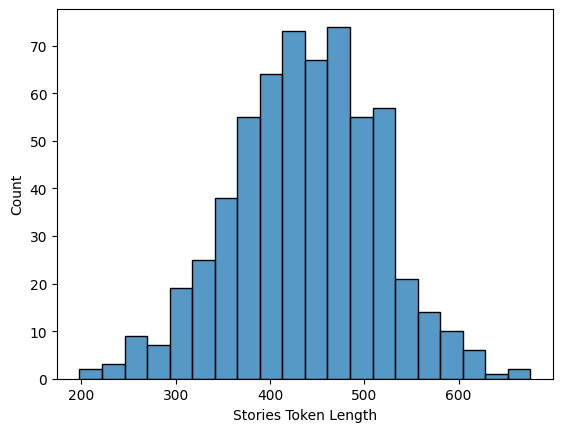

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize sentence length distribution for padding information
fig, ax = plt.subplots()
ax.set(xlabel='Stories Token Length', ylabel='Count')
sns.histplot(stories_len, ax=ax)
plt.show()

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 512 # BERT max length

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 2.2b BERT Classifier

Adapt BERT sentiment classifier from tutorial 9.

#### Train

In [ ]:
class StorySettingClassifier(nn.Module):

  def __init__(self, n_classes):
    super(StorySettingClassifier, self).__init__()
    # Model is simply BERT followed by a linear layer:
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    # Get the BERT pooled output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # BERT output through linear layer:
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
# class names: names of settings that we are trying to predict.
class_names = set(y_train_BERT)
class_names

{0, 1, 2, 3, 4}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = StorySettingClassifier(len(class_names))
model = model.to(device)

Set up training, hyperparameters etc. From Tutorial 9:

The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5: didn't learn, 3e-5, 2e-5: 'didn't learn'
- Number of epochs: 2, 3, 4

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


From Tutorial 9, a function to define 1 epoch of trainning: forward, backwards pass.

In [ ]:
# Define a function for training the model for one epoch.
def train_epoch(
  model,           # The model to be trained
  data_loader,     # DataLoader that provides batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  optimizer,       # Optimization algorithm to adjust model parameters based on gradients
  device,          # Device (CPU/GPU) on which the computation will be performed
  scheduler,       # Learning rate scheduler to adjust the learning rate over epochs
  n_examples       # Total number of examples in the dataset
):
  # Set the model to training mode (enables dropout, batch normalization, etc.)
  model = model.train()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  # Iterate over each batch in the data loader
  for d in data_loader:
    # Move the batch data to the specified device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    # Forward pass: compute the model outputs with input_ids and attention_mask
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # Compute the predictions by finding the index of the max logit
    _, preds = torch.max(outputs, dim=1)
    # Calculate the loss between the model outputs and true targets
    loss = loss_fn(outputs, targets)

    # Count correct predictions to calculate accuracy
    correct_predictions += torch.sum(preds == targets)
    # Append the loss of the current batch to the list
    losses.append(loss.item())

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    #debugging: view gradients
    gradients = model.out.weight.grad
    #print(gradients)

    # Clip gradients to prevent the exploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # Perform a single optimization step (parameter update)
    optimizer.step()
    # Update the learning rate
    scheduler.step()
    # Clear the gradients of all optimized variables
    optimizer.zero_grad()

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses)

Now we also define a function to evaluate model. Disabling gradient updates.

In [ ]:
# Define a function for evaluating the model's performance on a dataset.
def eval_model(
  model,           # The model to be evaluated
  data_loader,     # DataLoader providing batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  device,          # Device (CPU/GPU) on which the computation will be performed
  n_examples       # Total number of examples in the dataset
):
  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
  model = model.eval()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  # Disable gradient computation to save memory and computation during evaluation
  with torch.no_grad():
    # Iterate over each batch in the data loader
    for d in data_loader:
      # Move the batch data to the specified device
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      # Forward pass: compute the model outputs with input_ids and attention_mask
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      # Compute the predictions by finding the index of the max logit
      _, preds = torch.max(outputs, dim=1)

      # Calculate the loss between the model outputs and true targets
      loss = loss_fn(outputs, targets)

      # Count correct predictions to calculate accuracy
      correct_predictions += torch.sum(preds == targets)
      # Append the loss of the current batch to the list
      losses.append(loss.item())

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_10.bin') # save best model
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.5150268524885178 accuracy 0.2910602910602911
Val   loss 0.8964124023914337 accuracy 0.6804123711340206

Epoch 2/10
----------
Train loss 0.6475933885667473 accuracy 0.7796257796257797
Val   loss 0.24048283696174622 accuracy 0.9278350515463918

Epoch 3/10
----------
Train loss 0.15134349174331874 accuracy 0.9480249480249481
Val   loss 0.11995319277048111 accuracy 0.9690721649484536

Epoch 4/10
----------
Train loss 0.048313813502318226 accuracy 0.9854469854469855
Val   loss 0.0504490447929129 accuracy 0.979381443298969

Epoch 5/10
----------
Train loss 0.038893269971595146 accuracy 0.9916839916839917
Val   loss 0.002308866009116173 accuracy 1.0

Epoch 6/10
----------
Train loss 0.002103745013300795 accuracy 1.0
Val   loss 0.0012215416645631194 accuracy 1.0

Epoch 7/10
----------
Train loss 0.006308345013167127 accuracy 0.997920997920998
Val   loss 0.0009775048383744434 accuracy 1.0

Epoch 8/10
----------
Train loss 0.0011755983541661408 accuracy 1.0
Va

#### Test

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9586776859504132